# Housing EDA Notebook

## Import Data

In [53]:
# Setup Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

%matplotlib inline

# Display all rows and columns
pd.set_option("display.max_columns", None)

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [54]:
# Used for auto-formatting code
# terminal - pip install nb_black
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [55]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [56]:
# Import entire dataset
df_train = pd.read_csv("data/train.csv")  # id=1 to 1460
df_test = pd.read_csv("data/test.csv")  # id=1461-2919

# Save figures within notebook?
save_figures = 1  # 1 (yes); 0 (no)

<IPython.core.display.Javascript object>

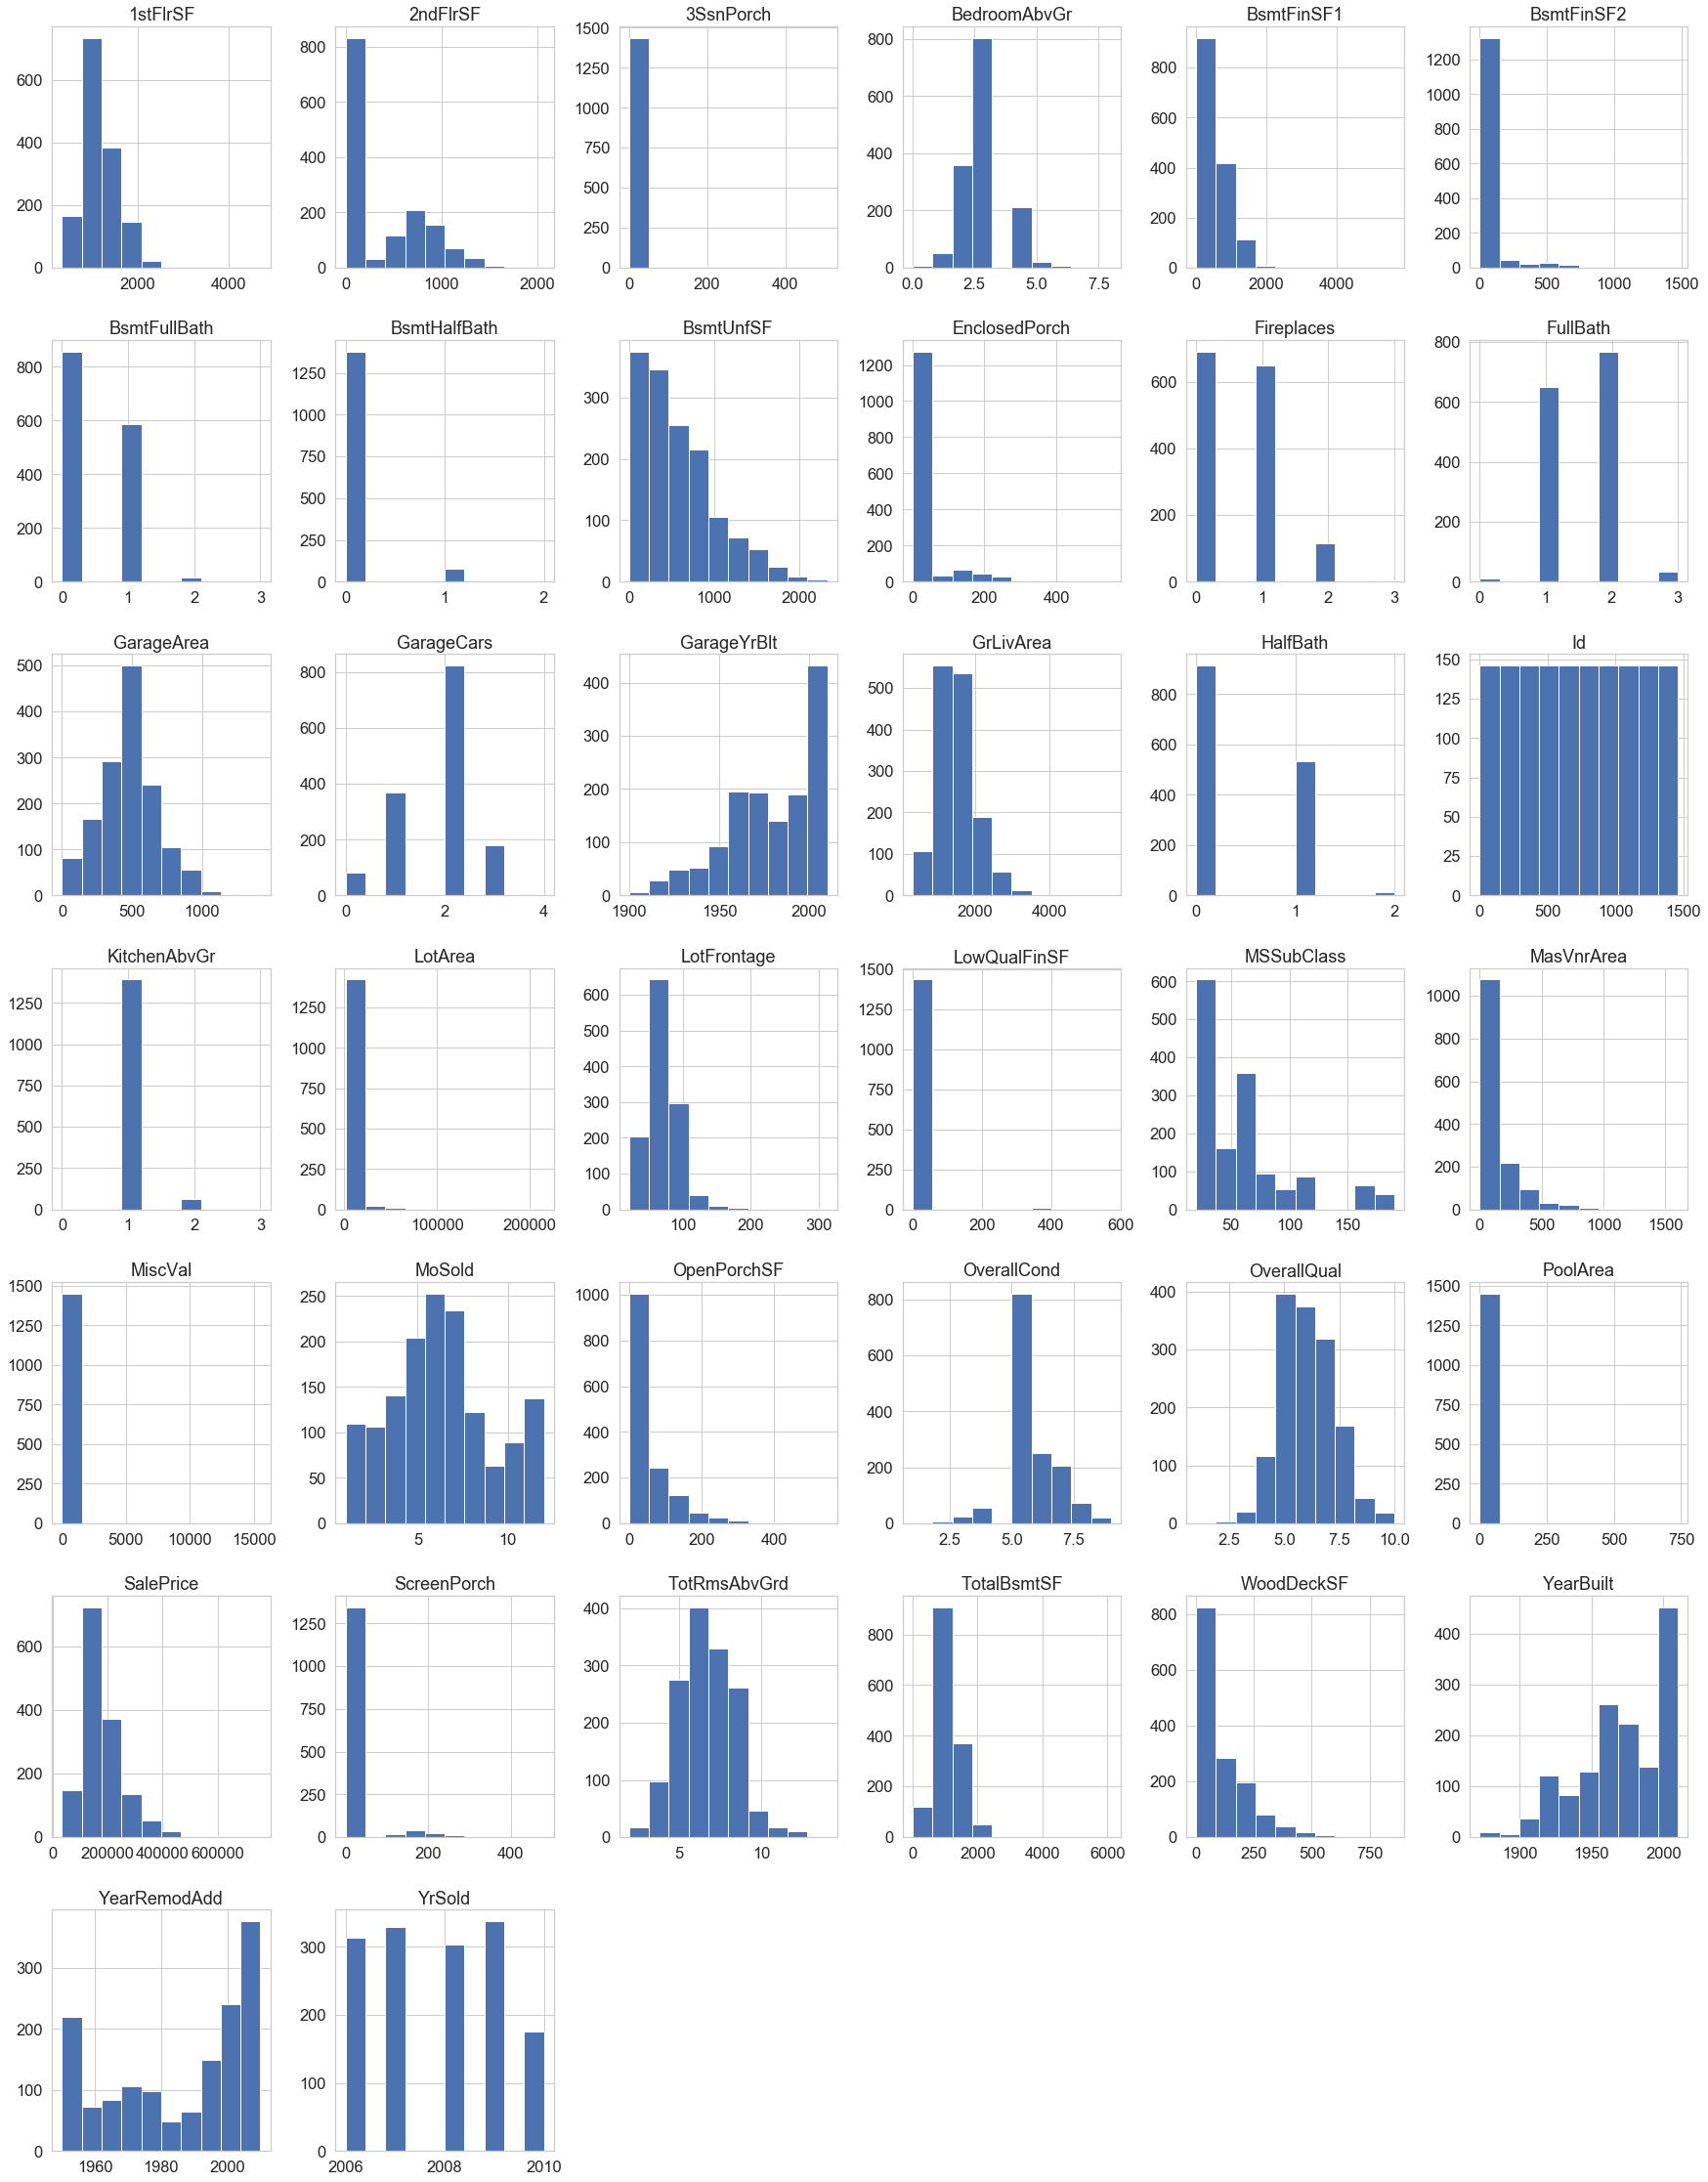

<IPython.core.display.Javascript object>

In [57]:
df_train.hist(figsize=(30, 40))  # viewing only train data
sns.set(style="whitegrid", font_scale=1.5)
plt.show()

## Explore Data

### Response Variable Transformation

**Original Response Variable**

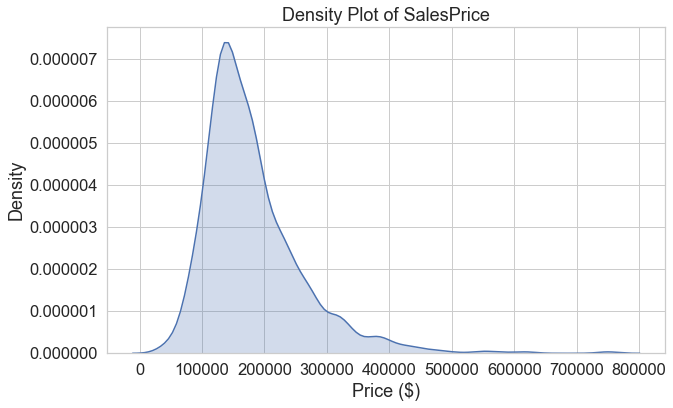

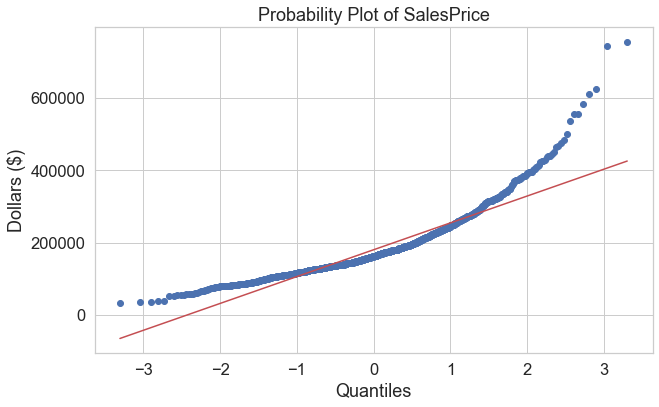

<IPython.core.display.Javascript object>

In [58]:
# Density plot of SalesPrice
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train.SalePrice, shade=True, legend=False)
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Density Plot of SalesPrice")
plt.xlabel("Price ($)")
plt.ylabel("Density")
if save_figures: plt.savefig("saved_figures/SalesPrice_density_plot.tiff", bbox_inches="tight", dpi=300)

# Probability plot of SalesPrice
plt.figure(figsize=(10, 6))
stats.probplot(df_train.SalePrice, plot=plt)
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Probability Plot of SalesPrice")
plt.xlabel("Quantiles")
plt.ylabel("Dollars ($)")
if save_figures: plt.savefig("saved_figures/SalesPrice_pp_lot.tiff", bbox_inches="tight", dpi=300)



**Log of SalePrice**

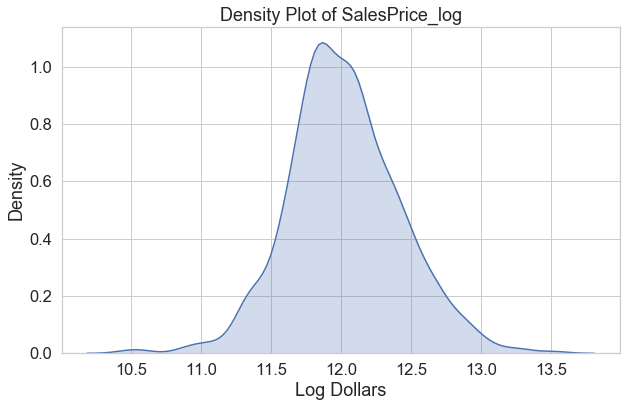

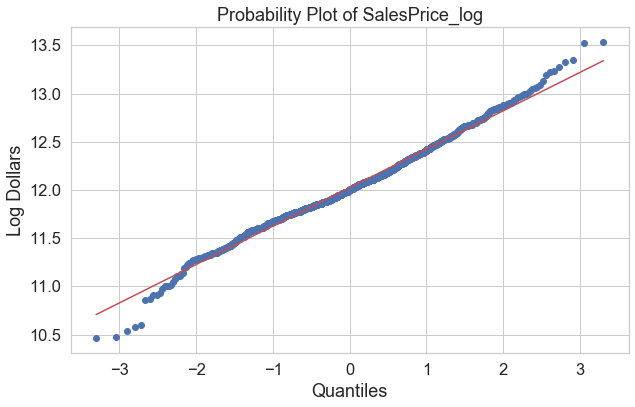

<IPython.core.display.Javascript object>

In [59]:
df_train["SalePrice_log"] = np.log(df_train.SalePrice)  # log transform SalesPrice

# Density plot of SalesPrice_log
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train.SalePrice_log, shade=True, legend=False)
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Density Plot of SalesPrice_log")
plt.xlabel("Log Dollars")
plt.ylabel("Density")
if save_figures: plt.savefig("saved_figures/SalesPriceLOG_density_plot.tiff", bbox_inches="tight", dpi=300)

# Probability plot of SalesPrice_log
plt.figure(figsize=(10, 6))
stats.probplot(df_train.SalePrice_log, plot=plt)
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Probability Plot of SalesPrice_log")
plt.xlabel("Quantiles")
plt.ylabel("Log Dollars")
if save_figures: plt.savefig("saved_figures/SalesPriceLOG_pp_plot.tiff", bbox_inches="tight", dpi=300)


### Corrleation Matrix

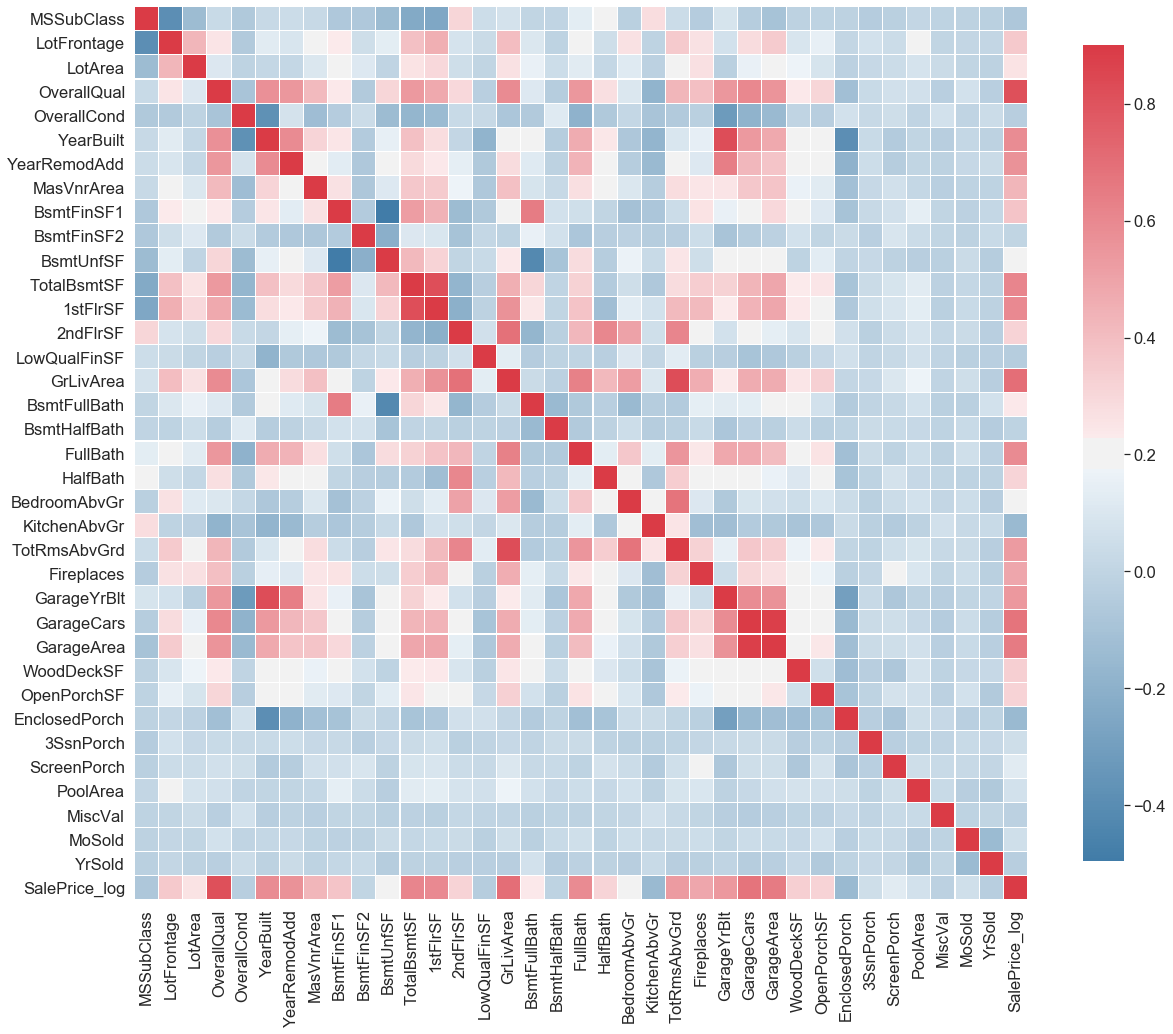

<IPython.core.display.Javascript object>

In [60]:
# Correlation of numeric features with Response Variable
df_correlation = df_train.drop(["Id", "SalePrice"], axis=1).corr()  # df of rho values
plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(240, 10, as_cmap=True)  # color map
sns.heatmap(
    df_correlation,
    vmax=0.9,
    square=True,
    linewidths=0.1,
    cbar_kws={"shrink": 0.75},
    cmap=cmap,
)
sns.set(font_scale=1.5)
if save_figures:
    plt.savefig("saved_figures/correlation_matrix.tiff", bbox_inches="tight", dpi=300)

### Removing Outliers

(1447, 82)

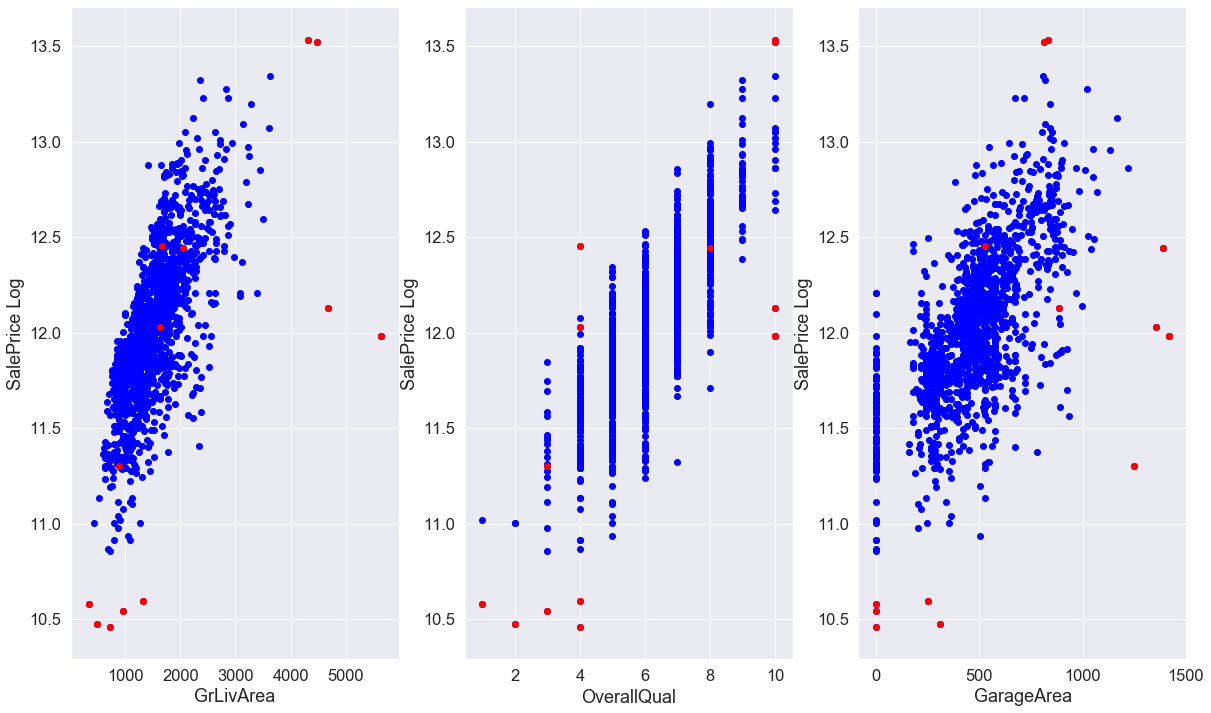

<IPython.core.display.Javascript object>

In [61]:
# Remove specific outliers based on plots
condition_dic = {
    "cond1": df_train["GrLivArea"] > 4000,
    "cond2": (df_train["OverallQual"] == 4) & (df_train["SalePrice_log"] > 12.2),
    "cond3": (df_train["GarageArea"] > 1200) & (df_train["SalePrice_log"] < 12.5),
    "cond4": (df_train["GrLivArea"] < 1500) & (df_train["SalePrice_log"] < 10.7),
}

outlier_dic = {
    "GrLivArea": np.where(condition_dic["cond1"])[0].tolist()
    + np.where(condition_dic["cond4"])[0].tolist(),
    "OverallQual": np.where(condition_dic["cond2"])[0].tolist(),
    "GarageArea": np.where(condition_dic["cond3"])[0].tolist(),
}

# Plot Outliers
plt.figure(figsize=(20, 12))
outliers = sum([outlier_dic[feat] for feat in outlier_dic], [])  # combine nested list
position = 1  # determines location in plot
for feat in outlier_dic:
    plt.subplot(1, 3, position)
    plt.scatter(x=df_train[feat], y=df_train["SalePrice_log"], c="blue")
    plt.scatter(
        x=df_train[feat].iloc[outliers],
        y=df_train["SalePrice_log"].iloc[outliers],
        c="red",
    )
    plt.ylabel("SalePrice Log")
    plt.xlabel(feat)
    plt.rcParams.update({"font.size": 12})
    position += 1  # for plot

if save_figures:
    plt.savefig("saved_figures/outlier_plot.tiff", bbox_inches="tight", dpi=300)


# Remove outliers
df_train.drop(df_train.iloc[outliers].index, inplace=True)
df_train.shape

## Address Missing Values

### Pseudo-missing data
Several features use NA to indicate a lack of a specific feature of the house (data_description.txt)
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- GarageType
- GarageFinish
- GarageQual
- GarageCond
- PoolQC
- Fence
- FireplaceQu
- MiscFeature
- Alley
- PoolQC

In [62]:
# Combine datasets
Y = df_train["SalePrice_log"]  # response variable
X = pd.concat(
    [df_train.drop(["SalePrice", "SalePrice_log"], axis=1), df_test],
    axis=0,
    join="outer",
    ignore_index=True,
)  # combined predictor features


<IPython.core.display.Javascript object>

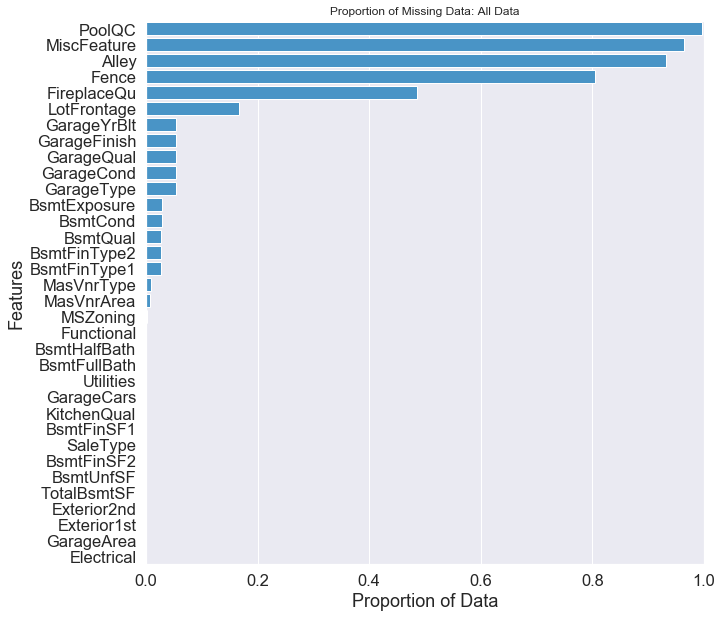

<IPython.core.display.Javascript object>

In [63]:
# View missing-ness in data
from preprocess_module import missValue_quant

missing_all = missValue_quant(X)  # missingness stats for all predictors

# Plot all missing methods
plt.figure(figsize=(10, 10))
sns.barplot(x=missing_all.perc_miss, y=missing_all.index, color="#3498db")
sns.set(style="whitegrid", font_scale=1)
plt.title("Proportion of Missing Data: All Data")
plt.xlabel("Proportion of Data")
plt.ylabel("Features")
plt.xlim(0, 1)

if save_figures:
    plt.savefig(
        "saved_figures/proportion_missing_data.tiff", bbox_inches="tight", dpi=300
    )

In [64]:
# Replace pseudo-missing values with 'None'
nonNA_list = [
    "Alley",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "BsmtQual",
    "Fence",
    "FireplaceQu",
    "GarageCond",
    "GarageFinish",
    "GarageQual",
    "GarageType",
    "MiscFeature",
    "PoolQC",
]

[X[feat].fillna("None", inplace=True) for feat in nonNA_list]
print("Pseudo-Missing features imputed with None")

Pseudo-Missing features imputed with None


<IPython.core.display.Javascript object>

### Actual-missing data


In [65]:
# Identify actual NAs by comparing related features
# Ex: Observation cannot have a BsmtQual grade, but NA for BsmtExposure indicating No Basement

from preprocess_module import id_actual_NA

X = id_actual_NA(X)
missValue_quant(X)

Actual-missing values correctly identified


,n_miss,perc_miss
LotFrontage,484,0.166552
GarageYrBlt,156,0.053682
MasVnrType,24,0.008259
MasVnrArea,23,0.007915
MSZoning,4,0.001376
BsmtCond,3,0.001032
BsmtExposure,3,0.001032
PoolQC,3,0.001032
Utilities,2,0.000688
Functional,2,0.000688


<IPython.core.display.Javascript object>

### Imputation

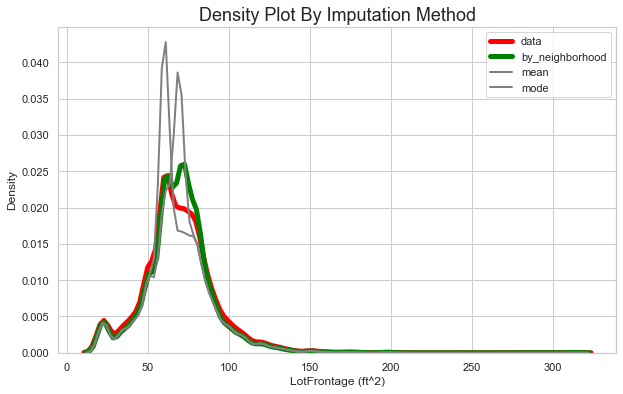

<IPython.core.display.Javascript object>

In [66]:
# Impute by cumulative mean value
mean_imp = X["LotFrontage"].fillna(X["LotFrontage"].mean())

# Impute by mode value
vals = X["LotFrontage"].loc[X["LotFrontage"].notna()].tolist()
lf_mode = max(set(vals), key=vals.count)
mode_imp = X["LotFrontage"].fillna(lf_mode)


# Impute by mean per neighborhood
bynbhood_imp = X.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# Plot density plot of various imputations methods
# format data for plot
imputation_df = pd.DataFrame(
    {
        "data": X.LotFrontage.loc[X.LotFrontage.notna()],
        "by_neighborhood": bynbhood_imp,
        "mean": mean_imp,
        "mode": mode_imp,
    }
)


# Plot all imputation methods
plt.figure(figsize=(10, 6))
for method in imputation_df.columns:

    color_dict = {
        "data": "red",
        "by_neighborhood": "green",
        "mean": "grey",
        "mode": "grey",
    }

    if method in ["data", "by_neighborhood"]:
        kde_kws = {"linewidth": 5}
    else:
        kde_kws = {"linewidth": 2}

    sns.distplot(
        imputation_df[method],
        hist=False,
        kde=True,
        kde_kws=kde_kws,
        label=method,
        color=color_dict[method],
    )
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Density Plot By Imputation Method")
plt.xlabel("LotFrontage (ft^2)")
plt.ylabel("Density")

if save_figures:
    plt.savefig("saved_figures/imputation_example.tiff", bbox_inches="tight", dpi=300)
# ==============================================================
# Based on the figure, imputation by neighborhood mean is most accurate method
X["LotFrontage"] = bynbhood_imp

In [67]:
# Additional categorical features imputed with mode value
feats = [
    "Exterior1st",
    "Exterior2nd",
    "MSZoning",
    "Functional",
    "SaleType",
    "Electrical",
]

for feat in feats:
    X[feat] = X.groupby(["Neighborhood"])[feat].transform(
        lambda x: x.fillna(x.mode()[0])
    )

<IPython.core.display.Javascript object>

In [68]:
# Features to impute with 0
feats = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
           'BsmtHalfBath','GarageCars','GarageArea']
for feat in feats:
    X[feat].fillna(0, inplace=True)


<IPython.core.display.Javascript object>

In [69]:
# Features to impute with 'None'
feats = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1',
           'BsmtFinType2','FireplaceQu', 'GarageFinish','GarageQual',
           'GarageType', 'GarageCond', 'PoolQC', 'Fence','MiscFeature','KitchenQual']

for feat in feats:
    X[feat].fillna(0, inplace=True)


<IPython.core.display.Javascript object>

In [70]:
# Drop features irrelevant due to number imbalance
X.drop(['Utilities'], axis= 1, inplace=True)

#Drop GarageYrBlt because some houses do not have garages
X.drop(['GarageYrBlt'], axis= 1, inplace=True)


<IPython.core.display.Javascript object>

## Feature Engineering

#### Continuous Features

In [71]:
# Total bathrooms = Full bath + 0.5*Halfbath (for both house and basement)
X["TotBaths"] = (
    X["FullBath"] + X["BsmtFullBath"] + 0.5 * X["HalfBath"] + 0.5 * X["BsmtHalfBath"]
)

# Total porch SF = OpenPorchSF + EnclosedSF + 3SsnPorch + ScreenPorch
X["TotPorchSF"] = (
    X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
)

# Total area of house = Above ground living area + basement living area
X["TotalSF"] = X["1stFlrSF"] + X["2ndFlrSF"] + X["TotalBsmtSF"]

# Age = Year sold - year built
X["Age"] = X["YrSold"].astype("float64") - X["YearBuilt"]

# # HasHouseRemod = 0 (no) or 1 (yes)
# X["HasHouseRemod"] = np.where(X["YearBuilt"] - X["YearRemodAdd"] > 0, 1, 0)

# Has Pool = 0 (no) or 1 (yes)
X["PoolArea"] = np.where(X["PoolArea"] > 0, 1, 0)

eng_feat = ["TotalSF", "TotPorchSF", "Age"]  # , "Age", "TotPorchSF", "TotBaths"]

cont_vars = [
    "1stFlrSF",
    "2ndFlrSF",
    "3SsnPorch",
    "BedroomAbvGr",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "EnclosedPorch",
    "Fireplaces",
    "GarageArea",
    "GarageCars",
    "GrLivArea",
    "LotArea",
    "LotFrontage",
    "LowQualFinSF",
    "MasVnrArea",
    "MiscVal",
    "MoSold",
    "OpenPorchSF",
    "ScreenPorch",
    "TotRmsAbvGrd",
    "TotalBsmtSF",
    "WoodDeckSF",
    "YearBuilt",
    "YearRemodAdd",
] + eng_feat

# Standardize datatypes
for feat in cont_vars:
    X[feat] = X[feat].astype("float64")

<IPython.core.display.Javascript object>

In [72]:
# Boxcox Transformation of Continuous Features
store = []
for feat in cont_vars:
    orig_skew = abs(stats.skew(X[feat]))
    log_skew = abs(stats.skew(np.log1p(X[feat])))

    if log_skew < orig_skew:
        X[feat] = np.log1p(X[feat])
        box_skew = abs(stats.skew(np.log1p(X[feat])))

        if (log_skew > 0.75) & (box_skew < log_skew):
            X[feat] = np.log1p(X[feat])
            final_skew = box_skew
            method = "boxcox"
        else:
            final_skew = log_skew
            method = "log"
    else:
        final_skew = orig_skew
        method = "none"
    store.append([feat, orig_skew, final_skew, method])

pd.DataFrame(store, columns=["feat", "orig_skew", "final_skew", "method"])

,feat,orig_skew,final_skew,method
0,1stFlrSF,1.263613,0.042776,log
1,2ndFlrSF,0.840297,0.305439,log
2,3SsnPorch,11.350139,8.721525,boxcox
3,BedroomAbvGr,0.331196,0.331196,none
4,BsmtFinSF1,0.974558,0.619201,log
5,BsmtFinSF2,4.135472,2.374173,boxcox
6,BsmtUnfSF,0.914666,0.914666,none
7,EnclosedPorch,4.007868,1.903061,boxcox
8,Fireplaces,0.724546,0.234349,log
9,GarageArea,0.171506,0.171506,none


<IPython.core.display.Javascript object>

#### Ordinal Features

In [73]:
# Convert ordinal categorical data to numeric value

ord_vars = [
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "BsmtQual",
    "ExterCond",
    "ExterQual",
    "FireplaceQu",
    "GarageCond",
    "GarageFinish",
    "GarageQual",
    "HeatingQC",
    "KitchenQual",
    "OverallCond",
    "OverallQual",
    "PavedDrive",
]

from preprocess_module import convert_ordinal_data
X = convert_ordinal_data(X, ord_vars)

# Standardize datatypes
for feat in ord_vars:
    X[feat] = X[feat].astype("float64")


Ordinal data conversion complete


<IPython.core.display.Javascript object>

In [74]:
# Power Transformation for Ordinal Features
store = []
for feat in ord_vars:
    orig_skew = abs(stats.skew(X[feat]))
    sqrt_skew = abs(stats.skew(np.power(X[feat], 0.5)))
    power_skew = abs(stats.skew(np.power(X[feat], 2)))
    cube_skew = abs(stats.skew(np.power(X[feat], 3)))

    if sqrt_skew < orig_skew:
        X[feat] = np.power(X[feat], 0.5)
        method = "x^0.5"
    elif power_skew < orig_skew:
        if cube_skew < power_skew:
            X[feat] = np.power(X[feat], 3)
            method = "x^3"
        else:
            X[feat] = np.power(X[feat], 2)
            method = "x^2"
    else:
        method = "none"
    final_skew = abs(stats.skew(X[feat]))

    store.append([feat, orig_skew, final_skew, method])

pd.DataFrame(store, columns=["feat", "orig_skew", "power_skew", "method"])

,feat,orig_skew,power_skew,method
0,BsmtCond,3.602871,0.729328,x^2
1,BsmtExposure,1.123630,0.208077,x^0.5
2,BsmtFinType1,0.149949,0.149949,none
3,BsmtFinType2,3.145787,1.286889,x^0.5
4,BsmtQual,1.272366,0.356528,x^2
5,ExterCond,1.335256,0.599243,x^0.5
6,ExterQual,0.787354,0.607427,x^0.5
7,FireplaceQu,0.172660,0.025517,x^0.5
8,GarageCond,3.407741,0.511014,x^3
9,GarageFinish,0.507782,0.462052,x^2


<IPython.core.display.Javascript object>

#### Categorical Features

In [75]:
cat_vars = [
    "Alley",
    "BldgType",
    "BldgType",
    "BsmtFullBath",
    "BsmtHalfBath",
    "CentralAir",
    "Condition1",
    "Condition2",
    "Electrical",
    "Exterior1st",
    "Exterior2nd",
    "Fence",
    "Foundation",
    "FullBath",
    "Functional",
    "GarageType",
    "HalfBath",
    "Heating",
    "HouseStyle",
    "KitchenAbvGr",
    "LandContour",
    "LandSlope",
    "LotConfig",
    "LotShape",
    "MSSubClass",
    "MSZoning",
    "MasVnrType",
    "MiscFeature",
    "Neighborhood",
    "PoolArea",
    "PoolArea",
    "PoolQC",
    "RoofMatl",
    "RoofStyle",
    "SaleCondition",
    "SaleType",
    "Street",
    "YrSold",
]

# RoofMatl: Simplify variety of values
X["RoofMatl"].replace(
    ["Membran", "ClyTile", "Metal", "Roll", "WdShngl", "WdShake"], "Other", inplace=True
)

# Condition1 & 2: Simplify variety of values
for feat in ["Condition1", "Condition2"]:
    X[feat].replace(["RRAn", "RRAe"], "Norm", inplace=True)
    X[feat].replace(["RRNn", "Artery", "Feedr"], "Other", inplace=True)
    X[feat].replace(["PosA", "PosN"], "Pos", inplace=True)

# Heating: Simplify variety of values
X["Heating"].replace(["Wall", "OthW", "Floor"], "Other", inplace=True)

# MiscFeature: Simplify variety of values
X["MiscFeature"].replace(["TenC", "Othr", "Gar2"], "Other", inplace=True)

for feat in cat_vars:
    X[feat] = X[feat].astype("str")

<IPython.core.display.Javascript object>

## Export Data for ML portion of project

In [76]:
# Sanity Check before exporting data
missValue_quant(X)

No missing values


<IPython.core.display.Javascript object>

In [77]:
X.to_csv("data/predictors.csv", sep=",", header=True, index=False)
Y.to_csv("data/response.csv", sep=",", header=True, index=False)

<IPython.core.display.Javascript object>